This notebook does the telluric correction of SN spectra using the standard star observed in the same night of observations. 

In the reduction process the telluric correction is done after the fluxing to remove the telluric absorption features present in the redder part of the optical wavelength range (R1000R grism) due to the Earth's atmosphere.

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pdb
import astropy
from astropy.table import Table
import linecache
from astropy.io import ascii
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting.continuum import fit_continuum
from specutils.fitting import fit_lines
from spectres import spectres

First, let's access the standard star's spectrum. Since we are using the *specutils* package, we need to create a Spectrum1D object. For that we need to specify in which units are the wavelength and flux values (in this case Angstrom and telescope counts, respectively):

In [4]:
hdul=fits.open('/home/lara/ICE/Reduction/GTC52_20A/OB0007/gtc_osiris_A/Science/spec1d_0002578221-20200518-OSIRIS-OsirisLongSlitSpectroscopy-SPSTD_GD153_OSIRIS_20200518T214204.492.fits')
lam=hdul[1].data['OPT_WAVE']
flux=hdul[1].data['OPT_COUNTS']

spectrum = Spectrum1D(spectral_axis=lam*u.AA,flux=flux*u.ct)

The main idea is to "create" a spectrum equal to 1 throughout all wavelengths, except those that coincide to the telluric features. For that we need to mantain the standard (std) star's spectrum except on the telluric features were we should fit the continuum. Then, by dividing the std star's spectrum with this "fitting" we create the desired spectrum mentioned previously.

According to __[Smette et al. (2015)](https://arxiv.org/abs/1501.07239)__ (Molecfit paper) and __[Kausch et al. (2015)](https://arxiv.org/abs/1501.07265)__ (Molecfit applied to X-Shooter data) the wavelength ranges for the telluric features are approximately:
- O$_{2}$ absorption feature @ 6860 - 6940
- H$_{2}$O absorption feature @ $\sim$ 7200 - 7400
- O$_{2}$ absorption feature @ 7590 - 7700
- H$_{2}$O absorption feature @ $\sim$ 7900 - 8500

The O$_{2}$ ranges are from Table 4 of the second paper whereas the H$_{2}$O ranges were visually obtained from Figure 1 from the first paper. Nonetheless, as you will notice I readjusted the ranges considering the features present on the standard star used for the telluric correction (you should do it too).

There's also a dominant water absorption feature @ 9300 - 9450 $\overset{\circ}{A}$ which makes the science spectra noisy. I did not include it since we only considered the SN spectra up to $\lambda = 9000 \overset{\circ}{A}$ for the analysis.

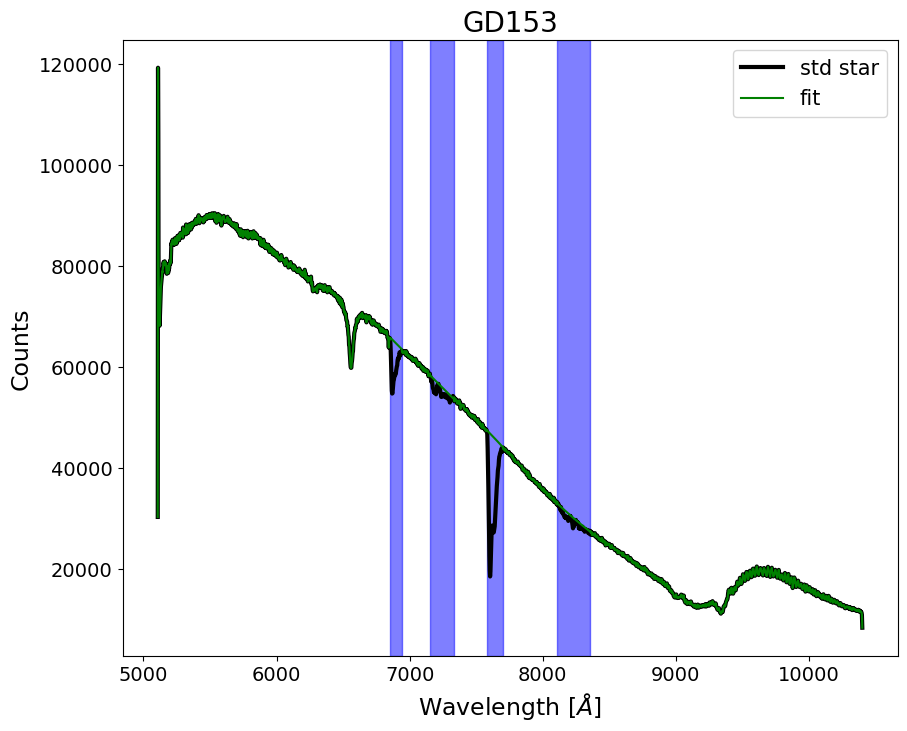

In [8]:
fig,ax=plt.subplots(1,1,figsize=(10,8))

#Create a list filled with NaNs with the same length as the variable flux
f = np.empty((len(flux),))
f[:] = np.nan

#Wavelength range before the first telluric feature should be equal to std star's spectrum
f[lam<6855]=flux[lam<6855]

###First Feature - O2
region=[(6700 * u.AA, 6825 * u.AA),(6950* u.AA, 7100 * u.AA)] #region to fit the continuum - do not consider telluric feature!
cont_fit = fit_continuum(spectrum, window=region)
y_continuum_fitted = cont_fit(lam*u.AA)

f[(lam>=6855)&(lam<=6940)]=y_continuum_fitted[(lam>=6855)&(lam<=6940)] #continuum fitting on the first telluric feature


###Second Feature - H2O
region=[(6950 * u.AA, 7150 * u.AA),(7300* u.AA, 7500 * u.AA)] #region to fit the continuum - do not consider telluric feature!
cont_fit = fit_continuum(spectrum, window=region)
y_continuum_fitted = cont_fit(lam*u.AA)


f[(lam>6940)&(lam<7155)]=flux[(lam>6940)&(lam<7155)] #Wavelength range between 1st and 2nd tell feature = to std star's spectrum
f[(lam>=7155)&(lam<=7332)]=y_continuum_fitted[(lam>=7155)&(lam<=7332)] #continuum fitting on the second telluric feature


###Third Feature - O2
region=[(7300 * u.AA, 7550 * u.AA),(7750* u.AA, 8000 * u.AA)] #region to fit the continuum - do not consider telluric feature!
cont_fit = fit_continuum(spectrum, window=region)
y_continuum_fitted = cont_fit(lam*u.AA)

f[(lam>7332)&(lam<7580)]=flux[(lam>7332)&(lam<7580)] #Wavelength range between 2nd and 3rd tell feature = to std star's spectrum
f[(lam>=7580)&(lam<=7700)]=y_continuum_fitted[(lam>=7580)&(lam<=7700)] #continuum fitting on the third telluric feature


###Fourth Feature - H2O
region=[(7800 * u.AA, 8100 * u.AA),(8360* u.AA, 8550 * u.AA)] #region to fit the continuum - do not consider telluric feature!
cont_fit = fit_continuum(spectrum, window=region)
y_continuum_fitted = cont_fit(lam*u.AA)

f[(lam>7700)&(lam<8110)]=flux[(lam>7700)&(lam<8110)] #Wavelength range between 3rd and 4th tell feature = to std star's spectrum
f[(lam>=8110)&(lam<=8357)]=y_continuum_fitted[(lam>=8110)&(lam<=8357)] #continuum fitting on the fourth telluric feature


f[lam>8357]=flux[lam>8357] #wavelength range after 4th feature = to std star's spectrum

#Plot the standard star's spectrum
plt.plot(lam,flux,lw=3,color='k',label='std star')

#Plot the "fit"
plt.plot(lam,f,color='green',label='fit')

plt.title('GD153',fontsize=20)
plt.xlabel('Wavelength [$\AA$]',fontsize=17)
plt.ylabel('Counts',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)

#Highlights the telluric absorption regions
ax.axvspan(6855, 6940, alpha=0.5, color='blue')
ax.axvspan(7155, 7332, alpha=0.5, color='blue')
ax.axvspan(7580, 7700, alpha=0.5, color='blue')
ax.axvspan(8110, 8357, alpha=0.5, color='blue')

#To save plot
plt.savefig('/home/lara/ICE/Reduction/GTC52_20A/OB0007/gtc_osiris_A/Science/'+'tell_fit.png', format='png', dpi=300, bbox_inches = "tight")

Then obtain the telluric correction spectrum by divind the std star's spectrum by the "fitting" and save it as a FITS file:

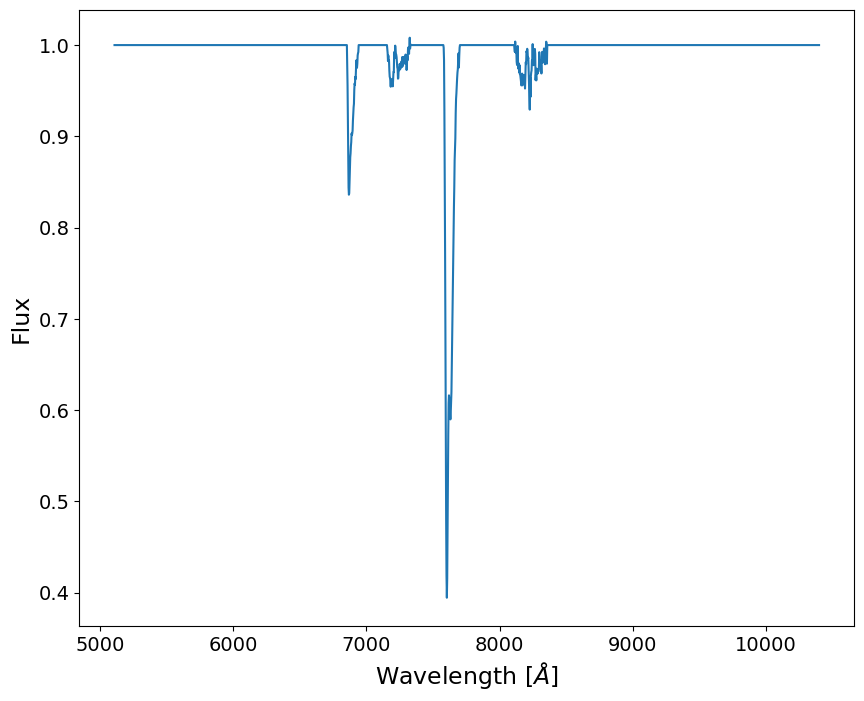

In [11]:
tell_corr=flux/f

fig,ax=plt.subplots(1,1,figsize=(10,8))
plt.plot(lam,tell_corr)

plt.xlabel('Wavelength [$\AA$]',fontsize=17)
plt.ylabel('Flux',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Save it as a FITS file
spectrum = Spectrum1D(spectral_axis=lam*u.AA,flux=tell_corr*u.ct)
spectrum.write("/home/lara/ICE/Reduction/GTC52_20A/OB0007/gtc_osiris_A/Science/tell_corr.fits",overwrite=True) 

Save in a .txt file the final telluric-corrected R1000R spectrum:

In [14]:
#Open the science spectrum that you wish to telluric-correct
hdul=fits.open('/home/lara/ICE/Reduction/GTC52_20A/OB0007/gtc_osiris_B/Science/spec1d_0002578248-20200518-OSIRIS-OsirisLongSlitSpectroscopy-ZTF20abaovyz_OSIRIS_20200519T031002.492.fits')
lam_r=hdul[1].data['OPT_WAVE']
spec_r=hdul[1].data['OPT_FLAM']*10**-17

#Open the telluric correction spectrum that you saved in the last step
hdul=fits.open('/home/lara/ICE/Reduction/GTC52_20A/OB0007/gtc_osiris_A/Science/tell_corr.fits')
tell=hdul[1].data['flux']

#Divide one by the other
flux_tellcorr=spec_r/tell

#Save it 
file = np.array([lam_r,flux_tellcorr])
file = file.T
with open('/home/lara/ICE/Reduction/final_txt/fits_to_txt/telluric_corrected/SN2020kjt_R1000R_tellcorr.txt', 'w+') as datafile_id:
    np.savetxt(datafile_id, file, fmt=['%f','%e'])

Now you have the final 1D flux-calibrated telluric-corrected spectrum! :)